In [1]:
from os.path import join

import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Variable

kookmin:  
국민대 학생 데이터(run 1개만 수행함) - 데이터 퀄리티는 더 좋음(Noise가 더 적음)

/mnt/sdb2/joystick/rawdata/test_kookmin/behavior_data_run1.pkl  
/mnt/sdb2/joystick/rawdata/test_kookmin/km_RMH_run1.csv


Seojin:  
국민대 학생 데이터(run 2개 수행함) - 데이터 퀄리티는 더 좋음(Noise가 더 많음

/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run1.csv  
/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run2.csv  

/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run1.pkl  
/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run2.pkl  

---

In [2]:
# df = pd.read_csv(join('/mnt/sdb2/joystick/preprocessed/test_kookmin','km_emg_run1_processed_30.csv')
#                  , sep=',', header=None, index_col=0)
# df

In [32]:
EMG = np.genfromtxt(join('/mnt/sdb2/joystick/preprocessed/test_kookmin','km_EMG_run1_processed_30.csv')
                     , delimiter=',', skip_header=True)
## the 1st column 
EMG = EMG[:,1:]
EMG.shape

(10, 669870)

In [4]:
joystick = np.load(join('/mnt/sdb2/joystick/rawdata/test_kookmin','behavior_data_run1.pkl')
                   , allow_pickle=True)

for key, value in joystick.items():
    joystick[key] = np.array(value)
    if joystick[key].shape[-1] < 2:
        joystick[key] = np.concatenate(joystick[key])
    print(joystick[key].shape)
joystick

(29300, 2)
(29300, 2)
(29300, 2)
(29300,)
(29300,)


{'cursor': array([[994, 575],
        [994, 575],
        [994, 575],
        ...,
        [702, 785],
        [701, 785],
        [701, 785]]),
 'target': array([[960, 540],
        [958, 539],
        [956, 538],
        ...,
        [674, 713],
        [674, 713],
        [673, 713]]),
 'joystick': array([[-0.00341797,  0.00331116],
        [-0.00341797,  0.00331116],
        [-0.00341797,  0.00331116],
        ...,
        [-0.55766296, -0.00341797],
        [-0.5098114 , -0.00341797],
        [-0.48919678, -0.02392578]]),
 'hit': array([1, 1, 1, ..., 0, 0, 0]),
 'time': array([1.88689232e-02, 3.59268188e-02, 5.32288551e-02, ...,
        6.91469816e+02, 6.91488928e+02, 6.91503995e+02])}

In [2]:
from matplotlib import patches
from matplotlib import animation, rc

In [66]:
# resolution = np.array([1920, 1080])
# scale = 1./120

# fig = plt.figure(figsize=np.array(resolution*scale).astype(np.int))
# ax = plt.axes(xlim=(0, resolution[0]), ylim=(0, resolution[1]))
# # fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

# ## background
# ax.set_facecolor((0., 0., 0.))

# live = []

# def init():
#     line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
#     line.set_data([], [])
    
#     target = patches.Circle((-100,-100), radius=35., fc='black', ec='white')
    
#     live.append(line)
#     live.append(ax.add_patch(target))
    
#     return live

# def animate(i):

#     live[0].set_data(joystick['cursor'][i,:])
#     live[1].set_center(joystick['target'][i,:]+np.array([35., 35.]))

#     if joystick['hit'][i]:
#         live[1].set(facecolor='crimson')
#     else:
#         live[1].set(facecolor='black')

#     return live

/tmp/ipykernel_576123/1621729728.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig = plt.figure(figsize=np.array(resolution*scale).astype(np.int))


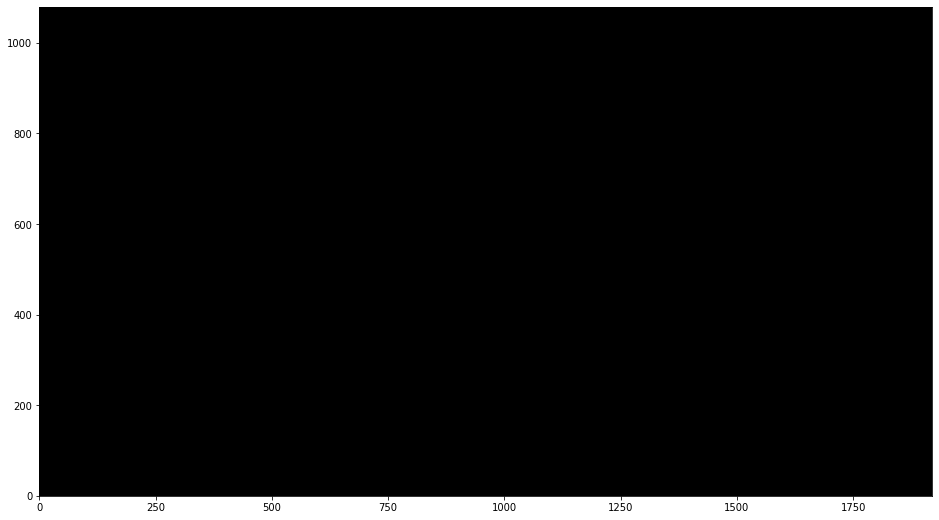

In [64]:
resolution = np.array([1920, 1080])
scale = 1./120

fig = plt.figure(figsize=np.array(resolution*scale).astype(np.int))
ax = plt.axes(xlim=(0, resolution[0]), ylim=(0, resolution[1]))
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

## background
ax.set_facecolor((0., 0., 0.))

live = []

def init():
    line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
    line.set_data([], [])
    
    target = patches.Circle((-100,-100), radius=35., fc='black', ec='white')
    
    live.append(line)
    live.append(ax.add_patch(target))
    
    return live

def animate(i):

    live[0].set_data(joystick['cursor'][i,:])
    live[1].set_center(joystick['target'][i,:]+np.array([35., 35.]))

    if joystick['hit'][i]:
        live[1].set(facecolor='crimson')
    else:
        live[1].set(facecolor='black')

    return live

In [65]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=1200, interval=16.7, blit=True)

rc('animation', html='html5')
anim

---

# Load EMG Data

In [2]:
# emg_run1_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run1.csv"
# emg_run2_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run2.csv"
path_km = '/mnt/sdb2/joystick/rawdata/test_kookmin/km_RMH_run1.csv'

In [3]:
f = open(path_km, 'r', encoding="cp949")
lines = f.readlines()
f.close()

In [4]:
for line_i in range(len(lines)):
    if len(lines[line_i].split(",")) > 1:
        start_record_index = line_i
        break

In [5]:
emg_header = lines[0:start_record_index]
emg_column = lines[start_record_index:start_record_index+1]
emg_datas = lines[start_record_index+1:]

In [6]:
isemg = emg_column[0].split(',')
for i in range(len(isemg)):
    if 'Quattro' in isemg[i]:
        isemg[i] = False
    elif 'EMG' in isemg[i]:
        isemg[i] = True
    else:
        isemg[i] = False
len(isemg)

140

In [7]:
np.array(emg_column[0].split(','))[isemg]

array(['R DELTOID: EMG 1 (IM) [Volts]',
       'R BICEPS BRACHII: EMG 2 (IM) [Volts]',
       'R TRICEPS BRACHII: EMG 3 (IM) [Volts]',
       'R FLEXOR CARPI RADIALIS: EMG 4 (IM) [Volts]',
       'R PALMARIS LONGUS: EMG 5 (IM) [Volts]',
       'R EXTENSOR CARPI RADIALIS: EMG 6 (IM) [Volts]'], dtype='<U50')

In [8]:
onset = []
emg = []
for t in range(len(emg_datas)):
    tmp = np.array(emg_datas[t].split(','))[isemg].astype(np.float)
    emg.append(tmp)
    tmp = np.array(emg_datas[t].split(','))[isemg[1:]+[False]].astype(np.float)
    onset.append(tmp)

/tmp/ipykernel_358564/4091347950.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp = np.array(emg_datas[t].split(','))[isemg].astype(np.float)
/tmp/ipykernel_358564/4091347950.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp = np.array(emg_datas[t].split(','))[isemg[1:]+[False]].astype(np.float)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

emg = scaler.fit_transform(np.array(emg))
# emg[emg<0] = 0
onset = np.array(onset)

In [10]:
print(emg.shape, onset.shape)

(783660, 6) (783660, 6)


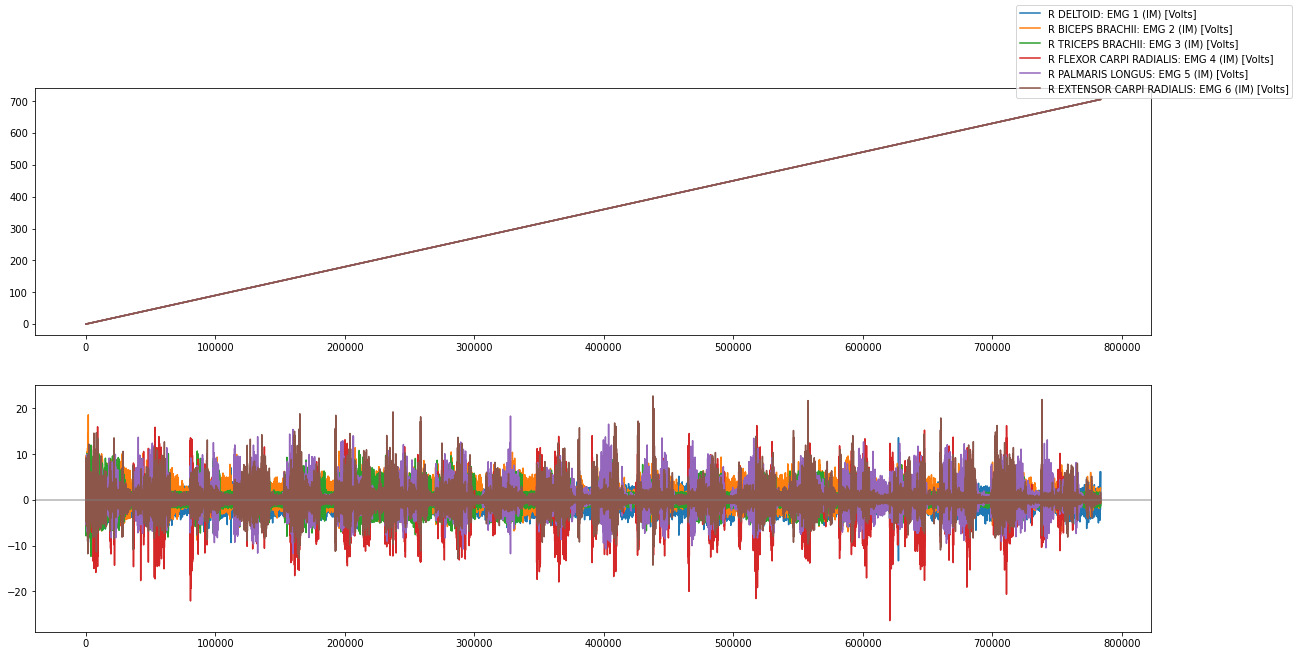

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

axs[0].plot(onset)
axs[1].plot(emg)
axs[1].axhline(0, color='gray', alpha=0.6)
fig.legend(np.array(emg_column[0].split(','))[isemg])

# Load Behavior Data

In [14]:
behavior_run1_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run1.pkl"
behavior_run2_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run2.pkl"
path_km = '/mnt/sdb2/joystick/rawdata/test_kookmin/behavior_data_run1.pkl'

In [15]:
f = open(path_km, 'rb') 

behav = pickle.load(f)

In [16]:
print('run01:')
for key, value in behav.items():
    print(key, np.array(value).shape)

run01:
cursor (29300, 2)
target (29300, 2)
joystick (29300, 2)
hit (29300, 1)
time (29300, 1)


# EMG downsampling per frame

In [17]:
behav['time'] = np.array(behav['time']).reshape(-1)

In [80]:
emg_downsamples = []

for ch in range(6):
    res = []
    tmp = onset[:,ch]
    ttmp = emg[:,ch]
    for t in behav['time']:
        res.append(np.sqrt(np.mean(ttmp[tmp < t]**2)))
        ttmp = ttmp[tmp > t]
        tmp = tmp[tmp > t]
    res = np.array(res)
    
    emg_downsamples.append(res)

In [85]:
emg_downsamples = np.array(emg_downsamples)

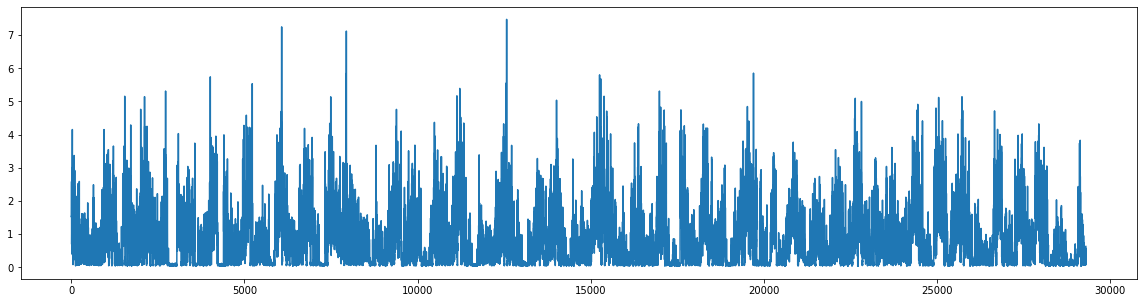

In [91]:
fig = plt.figure(figsize=(20,5))
plt.plot(emg_downsamples[4])

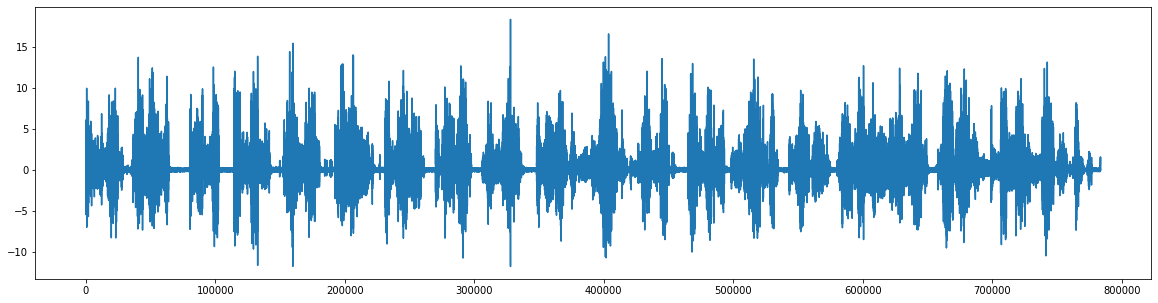

In [92]:
fig = plt.figure(figsize=(20,5))
plt.plot(emg[:,4])

# Calculate dx, dy

In [256]:
cursor_dx_dy = [(0,0)]
for i in range(len(behav["cursor"])):
    if i+1 < len(behav["cursor"]):
        # calculate from i to i+1
        dx = behav["cursor"][i+1][0] - behav["cursor"][i][0]
        dy = behav["cursor"][i+1][1] - behav["cursor"][i][1]
        cursor_dx_dy += [(dx,dy)]

In [257]:
len(cursor_dx_dy)

29300

# Input, output

In [264]:
X = pd.DataFrame({
    "R DELTOID": emg_downsamples[0],
    "R BICEPS BRACHII": emg_downsamples[1],
    "R TRICEPS BRACHII": emg_downsamples[2],
    "R FLEXOR CARPI RADIALIS": emg_downsamples[3],
    "R PALMARIS LONGUS": emg_downsamples[4],
    "R EXTENSOR CARPI RADIALIS": emg_downsamples[5]
})

In [266]:
# 마지막 EMG 데이터로는 예측할 label이 없으므로 삭제
X = X.iloc[0:len(X)]
Y = np.array(cursor_dx_dy)

In [267]:
X

,R DELTOID,R BICEPS BRACHII,R TRICEPS BRACHII,R FLEXOR CARPI RADIALIS,R PALMARIS LONGUS,R EXTENSOR CARPI RADIALIS
0,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
1,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
2,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
3,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
4,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
...,...,...,...,...,...,...
29295,1.415584,0.155676,0.455332,0.301279,0.375276,0.261823
29296,0.984428,0.146872,0.757229,0.191241,0.109166,0.159815
29297,0.868121,0.103724,0.767409,0.152484,0.132028,0.120191
29298,1.051079,0.102124,0.559608,0.216971,0.267347,0.214091


In [268]:
Y

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [ 0,  0],
       [-1,  0],
       [ 0,  0]])

In [269]:
print(len(X), len(Y))

29300 29300


In [248]:
from sklearn.model_selection import train_test_split

# LSTM

In [225]:
# https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch4-LSTM.html

In [302]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers, out_features):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.out_features = out_features
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=self.out_features)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [303]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset
            
            print(seq)
            print(seq.shape)
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [321]:
train_x  = torch.from_numpy(X)

TypeError: expected np.ndarray (got DataFrame)

In [318]:
model = LSTM(
    n_features=6,
    n_hidden=4,
    seq_len=1, # ??
    n_layers=1,
    out_features=2,
)
model, train_hist, val_hist = train_model(
    model,
    torch.tensor(X.to_numpy(), dtype=torch.double),
    torch.tensor(Y, dtype=torch.double),
    num_epochs=100,
    verbose=10,
    patience=50
)


tensor([6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994], dtype=torch.float64)
torch.Size([6])


RuntimeError: expected scalar type Double but found Float

In [285]:
torch.tensor(X.to_numpy()).shape

torch.Size([29300, 6])

tensor([[6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        [6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        [6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        ...,
        [0.8681, 0.1037, 0.7674, 0.1525, 0.1320, 0.1202],
        [1.0511, 0.1021, 0.5596, 0.2170, 0.2673, 0.2141],
        [0.5842, 0.1169, 0.3322, 0.1748, 0.6305, 0.2090]], dtype=torch.float64)

In [297]:
torch.unsqueeze(torch.tensor(X.to_numpy())[0], 0).shape

torch.Size([1, 6])

In [319]:
torch.tensor(X.to_numpy(), dtype = torch.DoubleTensor)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not torch.tensortype

In [311]:
torch.tensor(X.to_numpy(), torch.double)

TypeError: tensor() takes 1 positional argument but 2 were given